# Store Sales Forecasting
[Store Sales Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)
- Forecast sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer
- Product demand forecasting is a common data scientis attribution, specially relevant for brick-and-mortar grocery stores as they need to plan inventory accordingly
- Guess a little under, popular item sell out and you lose revenue
- Guess a little more and end up with lots of inventory

## Evaluation
- Evaluation metric will be Root Mean Squared Logarithmic Error
- RMSLE: `sqrt(sum(pow(log(1+ y_pred) - log(1 + y_true),2)))`

## Domain Context
- Ecuador economy is heavily dependent on oil prices
- Wages in public sector are paid every two weeks, on 15th and on the last day of the month
- Earthquake on April 16, 2016 had a huge impact on supermarket sales weeks after the event

# Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Checking data structure from top of csv files
- We are to predict **daily** `sales` for each **store** and **product family** on `test.csv`
- We are training on data from `train.csv`
- For simplicity we are to use linear regression models and we are modeling non-linearities in data through feature engineering

### Strategy 1: easy
- Build a simple linear regression model based on time-step and time-serial features (lag)
- Evaluate them under RMLSE

### Strategy 2: medium
- Model trend and seasonality, decompose it through a calendar-based fourier transform

### Strategy 3: hard
- Add holidays feature to reduce noise from data using `holiday_events.csv`
- May require investigation of `stores.csv` data to match local holidays
- trasferred column should be used as filter

### Strategy 4: nice to have
- Decide what to do with data after April 16, 2016 earthquake
- Add `num_days_since_last_payment` feature
- Seggregate models into store type / cluster if it seems to be different 
- Add oil prices into the regressions (if it has any impact at all)
- Add bridges to holidays

In [2]:
!ls inputs/

holidays_events.csv
oil.csv
sample_submission.csv
stores.csv
test.csv
train.csv
transactions.csv


In [3]:
!head -5 inputs/train.csv

id,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0


In [4]:
!head -5 inputs/test.csv

id,date,store_nbr,family,onpromotion
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20


In [5]:
!head -5 inputs/stores.csv

store_nbr,city,state,type,cluster
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9


In [6]:
!head -5 inputs/transactions.csv

date,store_nbr,transactions
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487


In [7]:
!head -5 inputs/oil.csv

date,dcoilwtico
2013-01-01,
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12


In [8]:
!head -5 inputs/holidays_events.csv

date,type,locale,locale_name,description,transferred
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False


## Import data and overall data analysis
- As we can see, test data is a prediction of the next days of sales on the supermarket
- Train data shows different patterns in the past, given that  we are to predict a small number of days in 2017, I would suggest to use only 2017 + data
- On 2017 cut `onpromotion` does not seem to be correlated with `sales`

In [9]:
train = pd.read_csv("inputs/train.csv", parse_dates=["date"], infer_datetime_format = True)

In [10]:
train = train.set_index(keys=["store_nbr","family","date"]).sort_index(ascending=True)

In [11]:
total_sales = train.drop("id", axis=1).groupby(level=["date"])["sales"].sum()
total_sales.head()

date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
Name: sales, dtype: float64

In [12]:
total_promotions = train.drop("id", axis=1).groupby(level=["date"])["onpromotion"].sum()
total_promotions.head()

date
2013-01-01    0
2013-01-02    0
2013-01-03    0
2013-01-04    0
2013-01-05    0
Name: onpromotion, dtype: int64

In [13]:
test = pd.read_csv("inputs/test.csv", parse_dates=["date"], infer_datetime_format = True)
test = test.set_index(keys=["store_nbr","family","date"]).sort_index(ascending=True)

In [14]:
total_fore_promotions = test.drop("id", axis=1).groupby(level=["date"])["onpromotion"].sum()
total_fore_promotions.head()

date
2017-08-16    30539
2017-08-17     7505
2017-08-18    13777
2017-08-19     8614
2017-08-20     9513
Name: onpromotion, dtype: int64

In [15]:
# visualize time series
import seaborn as sns

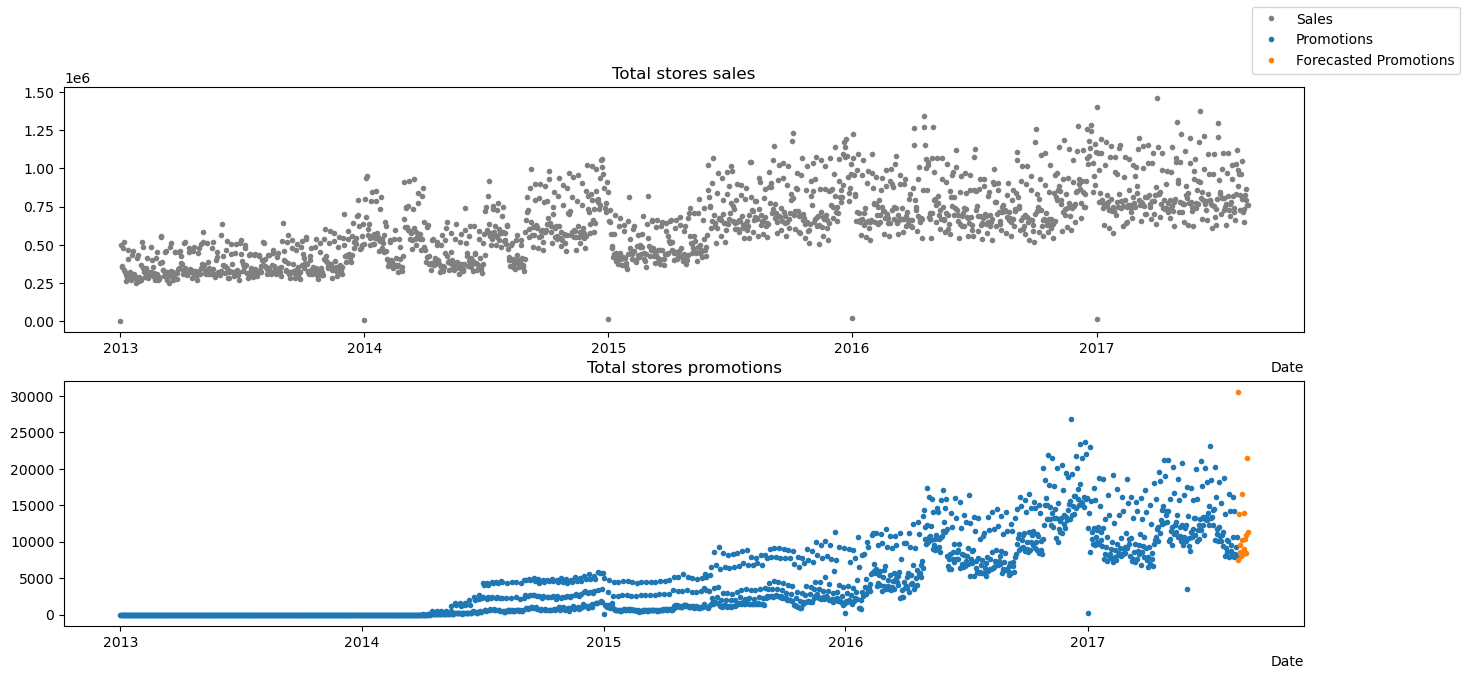

In [16]:
plot_params = {
    "figsize": (16,7)
}

fig, (ax_top, ax_down) = plt.subplots(nrows=2, ncols=1,**plot_params)

ax_top.plot(total_sales, ".", color='0.5', label="Sales")
ax_down.plot(total_promotions, ".", label="Promotions")
ax_down.plot(total_fore_promotions,".", label="Forecasted Promotions")

ax_top.set_title("Total stores sales")
ax_down.set_title("Total stores promotions")

ax_top.set_xlabel("Date",loc="right")
ax_down.set_xlabel("Date",loc="right")


fig.legend()

<Axes: xlabel='onpromotion', ylabel='sales'>

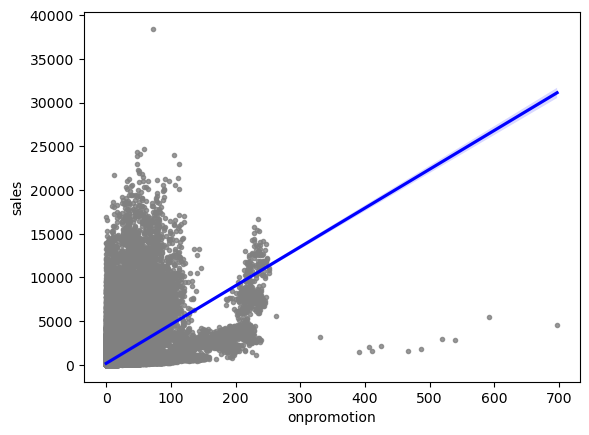

In [17]:
sns.regplot(x=train.loc[:, :, "2017"]["onpromotion"], y=train.loc[:, :, "2017"]["sales"],marker=".", color="0.5",line_kws={"color": "blue"})

Text(0.5, 1.0, 'Sales')

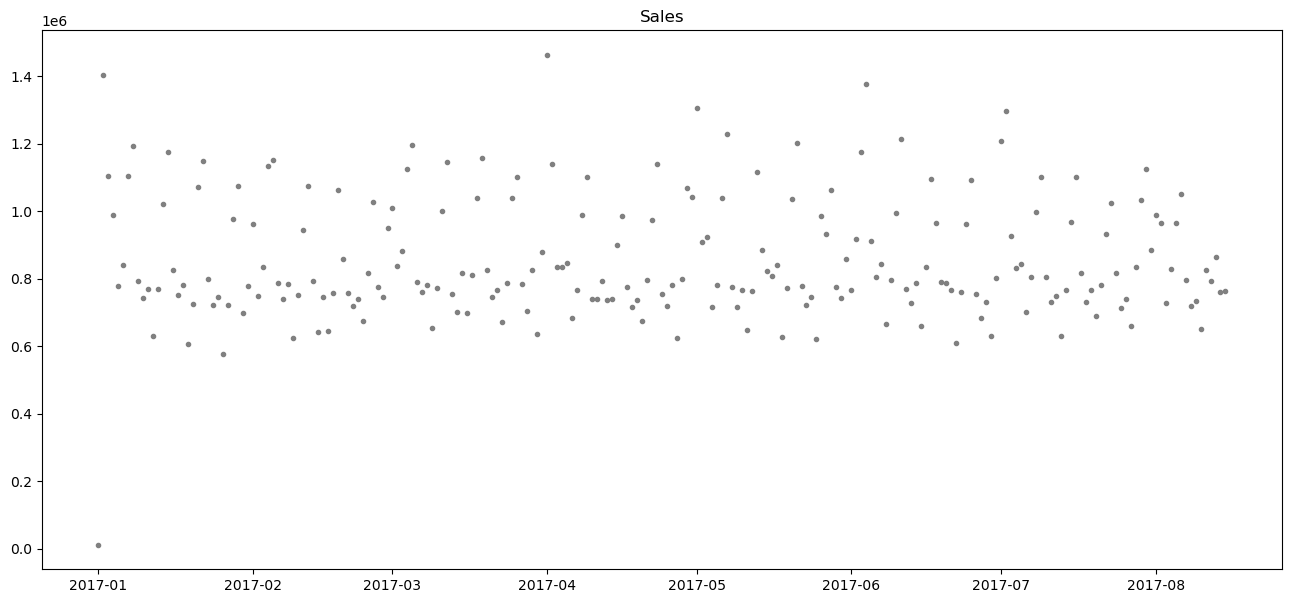

In [18]:
plot_params = {
    "figsize": (16,7)
}

fig, ax = plt.subplots(**plot_params)

ax.plot(total_sales.loc["2017"], ".", color='0.5', label="Sales")
ax.set_title("Sales")

# Modelling
## Strategy 1: Simple Linear Regressions

### Time-step features

In [19]:
from statsmodels.tsa.deterministic import DeterministicProcess

In [20]:
# Let's create the time step features

total_sales = train["sales"].groupby(level=["date"]).sum().sort_index(ascending=True).loc["2017"]

print(total_sales.head())

dp = DeterministicProcess(total_sales.index, order=1)

date
2017-01-01    1.208250e+04
2017-01-02    1.402306e+06
2017-01-03    1.104377e+06
2017-01-04    9.900935e+05
2017-01-05    7.776210e+05
Name: sales, dtype: float64


In [21]:
X = dp.in_sample()
X.head()

,trend
date,
2017-01-01,1.0
2017-01-02,2.0
2017-01-03,3.0
2017-01-04,4.0
2017-01-05,5.0


In [22]:
y = train["sales"].copy().unstack(["store_nbr","family"]).loc["2017"]
y.head()

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0        0.000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0      166.819   
2017-01-03        4.0       0.0    4.0    3081.0   2.0      519.348   
2017-01-04        1.0       0.0    4.0    3039.0   2.0      543.251   
2017-01-05        2.0       0.0    3.0    2617.0   0.0      533.480   

store_nbr                                         ...        54             \
family     CELEBRATION CLEANING   DAIRY     DELI  ... MAGAZINES      MEATS   
date                                              ...                        
2017-01-01         0.0      0.0     0.0    0.000  ...       0.0   0.000000   
2017-01-02         0.0    332.0   376.0   44.980  ...       1.0  57.447998   
2017-01-03        15.0    952.0  1045.0  209.300  ...       0.0  57.052000   
2017-01-04        17.0   1055.0  1029.0  135.944  ...       0.0  64.540000   
2017-01-05        40.0    918.0   853.0  137.006  ...       0.0  57.417000   

store_nbr                                                              \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2017-01-01           0.0          0.0                     0.0   0.000   
2017-01-02         315.0          1.0                     8.0  78.719   
2017-01-03         291.0          0.0                     6.0  72.347   
2017-01-04         228.0          0.0                     5.0  43.715   
2017-01-05         227.0          2.0                     5.0  75.235   

store_nbr                                                              
family     PREPARED FOODS  PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                   
2017-01-01            0.0    0.000                        0.0     0.0  
2017-01-02          126.0  475.658                        0.0     8.0  
2017-01-03           53.0  936.004                        0.0     1.0  
2017-01-04           98.0  754.560                        0.0     2.0  
2017-01-05           17.0  370.752                        0.0     0.0  

[5 rows x 1782 columns]

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
model = LinearRegression(n_jobs=3)
model.fit(X,y)

LinearRegression(n_jobs=3)

In [25]:
y_pred = pd.DataFrame(model.predict(X), index= y.index, columns=y.columns).stack(["store_nbr","family"]).rename("sales").reorder_levels(["store_nbr","family","date"])

In [26]:
# Log error cannot tolerate negative predicted values
print("Negative values to be zeroed: ",len(y_pred.loc[y_pred < 0]),"/", len(y_pred))
y_pred.loc[y_pred < 0] = 0.0

Negative values to be zeroed:  3570 / 404514


In [27]:
y_true = train.copy().loc[train.index.get_level_values(2) >= "2017-01-01"]["sales"]

In [28]:
%config InlineBackedn.figure_format = 'retina'

sns.set_style("whitegrid")

plt.rc(
    "figure",
    autolayout=True,
    figsize=(11,4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=16,
    titlepad=10,
)

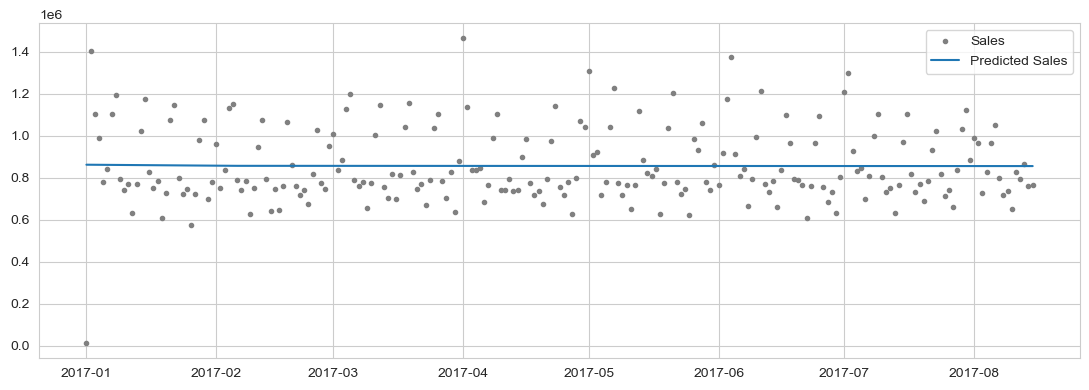

In [29]:
fig, ax = plt.subplots()
ax.plot(y_true.groupby(level=["date"]).sum(), ".", label="Sales", color="0.5")
ax.plot(y_pred.groupby(level=["date"]).sum(), label="Predicted Sales")
ax.legend()

In [30]:
from sklearn.metrics import mean_squared_log_error

In [31]:
mean_squared_log_error(y_true, y_pred)

12.51609278455633

### Lag features

I really have no idea how can I predict for multiple product families and stores with lag features.

- How should I separate lag features from one store-product to the other on train predictors' dataset?
- SHould I create one model per product / store

In [32]:
# Puts dates on rows and store_nbr and family as columns. values are the sales
sales_pivot = train.drop(["id","onpromotion"], axis=1)["sales"].unstack(["store_nbr","family"])
last_day_sales_pivot = sales_pivot.shift(1)

In [33]:
lag_1_df = (
    pd.DataFrame(sales_pivot.stack(["store_nbr","family"]).reorder_levels(["store_nbr","family","date"]), columns=["sales"])
    .join(last_day_sales_pivot.stack(["store_nbr","family"]).reorder_levels(["store_nbr","family","date"]).rename("sales"), rsuffix="_lag_1")
)

In [34]:
lag_1_df.loc[lag_1_df.index.get_level_values(2) >= "2017-01-01"].head()

sales  sales_lag_1
store_nbr family     date                          
1         AUTOMOTIVE 2017-01-01    0.0          2.0
          BABY CARE  2017-01-01    0.0          0.0
          BEAUTY     2017-01-01    0.0          3.0
          BEVERAGES  2017-01-01    0.0       2318.0
          BOOKS      2017-01-01    0.0          1.0

In [35]:
X = lag_1_df.copy().loc[lag_1_df.index.get_level_values(2) >= "2017-01-01",["sales_lag_1"]]
y = lag_1_df.copy().loc[lag_1_df.index.get_level_values(2) >= "2017-01-01","sales"]

In [36]:
X["sales_lag_1"]

store_nbr  family                      date      
1          AUTOMOTIVE                  2017-01-01       2.000
           BABY CARE                   2017-01-01       0.000
           BEAUTY                      2017-01-01       3.000
           BEVERAGES                   2017-01-01    2318.000
           BOOKS                       2017-01-01       1.000
                                                       ...   
54         POULTRY                     2017-08-15      56.155
           PREPARED FOODS              2017-08-15     147.000
           PRODUCE                     2017-08-15     585.615
           SCHOOL AND OFFICE SUPPLIES  2017-08-15       0.000
           SEAFOOD                     2017-08-15       0.000
Name: sales_lag_1, Length: 404514, dtype: float64

Text(0.5, 1.0, 'Regression over lag feature - last day')

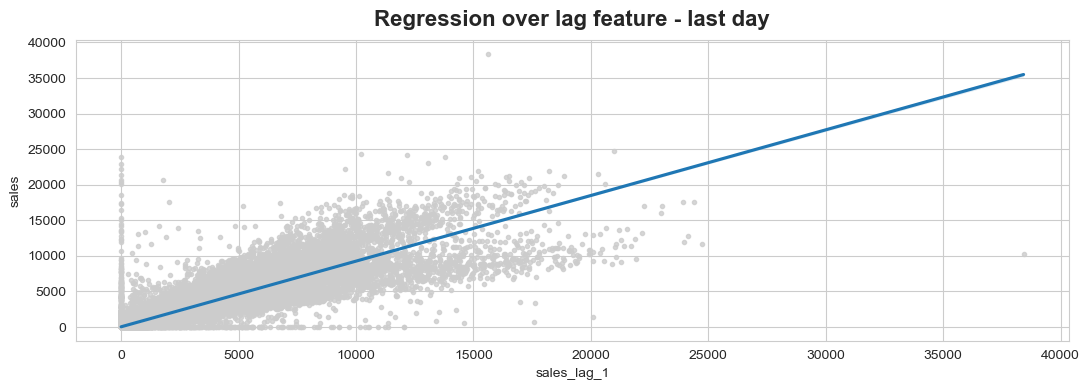

In [37]:
ax = sns.regplot(x=X["sales_lag_1"], y=y, marker= ".", scatter_kws={"color":"0.8"})
ax.set_title("Regression over lag feature - last day")

In [38]:
y.unstack(["store_nbr","family"])

store_nbr          1                                                 \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0      0.00000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0    166.81900   
2017-01-03        4.0       0.0    4.0    3081.0   2.0    519.34800   
2017-01-04        1.0       0.0    4.0    3039.0   2.0    543.25100   
2017-01-05        2.0       0.0    3.0    2617.0   0.0    533.48000   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0    145.60700   
2017-08-12        6.0       0.0    3.0    1659.0   0.0    243.22000   
2017-08-13        1.0       0.0    1.0     803.0   0.0    136.67900   
2017-08-14        1.0       0.0    6.0    2201.0   0.0    346.03800   
2017-08-15        4.0       0.0    4.0    1942.0   0.0    329.54102   

store_nbr                                         ...        54             \
family     CELEBRATION CLEANING   DAIRY     DELI  ... MAGAZINES      MEATS   
date                                              ...                        
2017-01-01         0.0      0.0     0.0    0.000  ...       0.0   0.000000   
2017-01-02         0.0    332.0   376.0   44.980  ...       1.0  57.447998   
2017-01-03        15.0    952.0  1045.0  209.300  ...       0.0  57.052000   
2017-01-04        17.0   1055.0  1029.0  135.944  ...       0.0  64.540000   
2017-01-05        40.0    918.0   853.0  137.006  ...       0.0  57.417000   
...                ...      ...     ...      ...  ...       ...        ...   
2017-08-11         4.0    341.0   343.0   64.302  ...       0.0  50.756000   
2017-08-12         3.0    351.0   526.0   99.488  ...       1.0  53.079002   
2017-08-13         1.0    169.0   266.0   47.770  ...       3.0  67.435000   
2017-08-14         4.0    571.0   699.0  154.578  ...       1.0  64.224000   
2017-08-15        21.0    703.0   602.0  116.402  ...       2.0  57.842000   

store_nbr                                                                 \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS    POULTRY   
date                                                                       
2017-01-01           0.0          0.0                     0.0   0.000000   
2017-01-02         315.0          1.0                     8.0  78.719000   
2017-01-03         291.0          0.0                     6.0  72.347000   
2017-01-04         228.0          0.0                     5.0  43.715000   
2017-01-05         227.0          2.0                     5.0  75.235000   
...                  ...          ...                     ...        ...   
2017-08-11         155.0          0.0                     0.0  80.759000   
2017-08-12         169.0          0.0                     4.0  91.671000   
2017-08-13         244.0          0.0                     2.0  79.062996   
2017-08-14         200.0          0.0                     1.0  56.155000   
2017-08-15         169.0          0.0                     2.0  59.619000   

store_nbr                                                              
family     PREPARED FOODS  PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                   
2017-01-01            0.0    0.000                        0.0     0.0  
2017-01-02          126.0  475.658                        0.0     8.0  
2017-01-03           53.0  936.004                        0.0     1.0  
2017-01-04           98.0  754.560                        0.0     2.0  
2017-01-05           17.0  370.752                        0.0     0.0  
...                   ...      ...                        ...     ...  
2017-08-11           54.0  546.250                        0.0     0.0  
2017-08-12           81.0  696.920                        0.0     1.0  
2017-08-13           91.0  877.304                     

In [39]:
model = LinearRegression(n_jobs=3)
# model.fit(X, y)

## Strategy 2

Model trend and seasonality decomposing through CalendarFourier

In order to do that we are creating two aux plots, seasonal plot and periodogram

In [40]:
def seasonal_plot(datetime_index_series):
    seasonal_df = datetime_index_series.index.isocalendar().astype(np.int64).join(datetime_index_series)
    fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(16,6))
                  
    for week in seasonal_df["week"].unique():
        week_df = seasonal_df.query(f"week == {week}")    
        ax.plot(week_df.day, week_df[datetime_index_series.name], label=f"Week: {week}")

    ax.legend(loc="lower center", ncols=11)
    ax.set_title(f"Seasonal Plot of {datetime_index_series.name}")
    ax.set_ylabel(datetime_index_series.name, loc='center')
    ax.set_xlabel("day of week", loc='center')

In [41]:
from scipy.signal import periodogram

In [42]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = 365.25
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window='boxcar',
        scaling='spectrum',
    )
    
    if ax is None:
        _, ax = plt.subplots()
    
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1,2,4,6,12,26,52,104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodgram")
    return ax

### Seasonal plot
- There seems to exist a weekly ans semi-weekly trend in the data, we can confirm that with periodogram

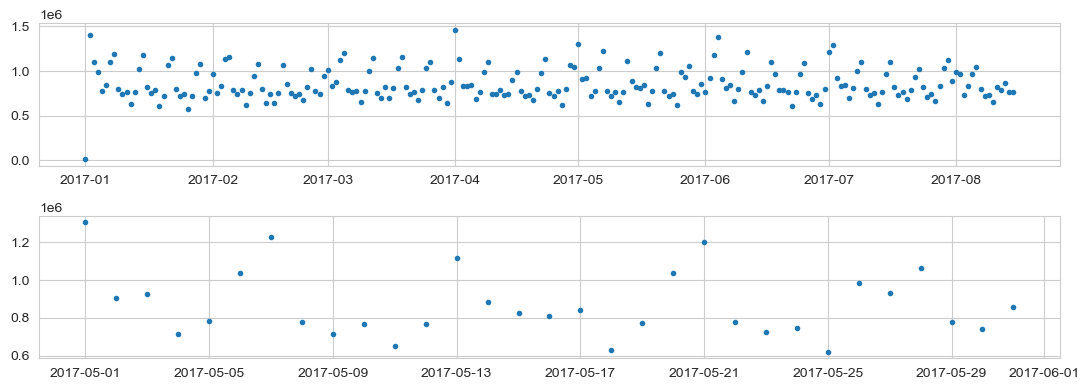

In [43]:
fig, (axtop, axbottom) = plt.subplots(2,1)
axtop.plot(total_sales,".")
axbottom.plot(total_sales.loc["2017-05"],".")

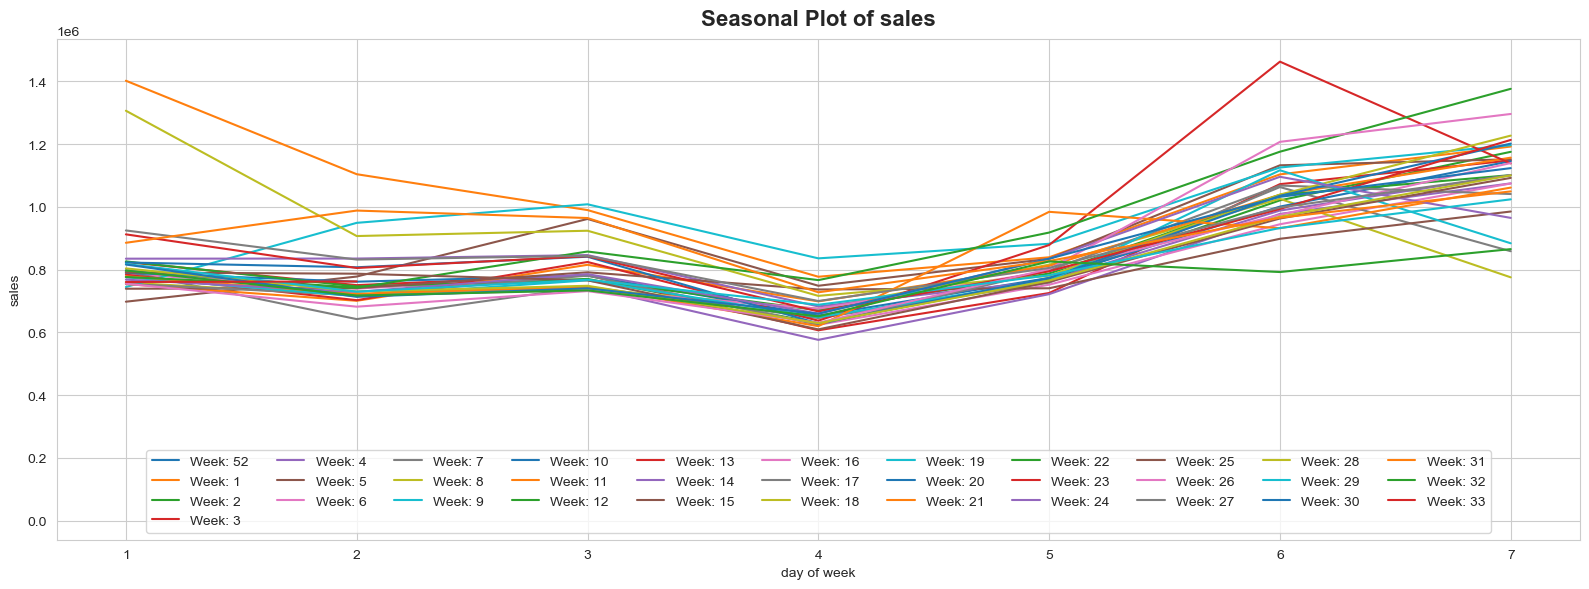

In [44]:
seasonal_plot(total_sales)

### Periodogram
- As expected, strong weekly and semi-weekly seasonalities
- Mild monthly and biweekly seasonalities

<Axes: title={'center': 'Periodgram'}, ylabel='Variance'>

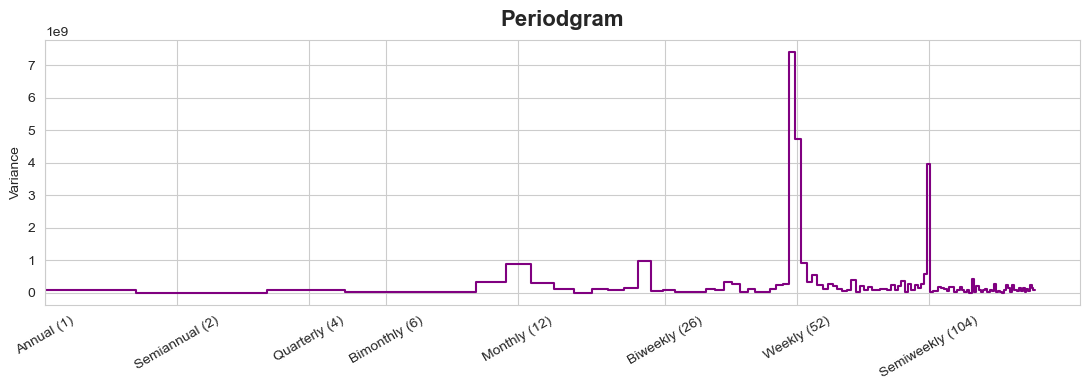

In [45]:
plot_periodogram(total_sales)

In [46]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

### Identifying Trend through moving average

In [47]:
def plot_regression(series=None, regression_series=None, ax=None, title=None):
    if ax is None:
        _, ax = plt.subplots()
    
    if series is not None:
        ax.plot(series, ".", color="0.8", label=series.name)
        ax.set_ylabel(series.name)
    
    if regression_series is not None:
        ax.plot(regression_series, label=regression_series.name)
    
    if title is not None:
        ax.set_title(title)
    
    ax.legend()
    
    ax.set_xlabel("Date")
    
    return ax

In [48]:
def plot_trend(series, trend_series, ax=None, plot_series=True, plot_trend=True):
    if ax == None:
        _, ax = plt.subplots()
    
    if plot_series:
        ax.plot(series, ".", color="0.8", label=series.name)
    
    if plot_trend:
        ax.plot(trend_series, label=trend_series.name)
    
    ax.legend()
    ax.set_title(f"Trend Plot of {series.name}")
    ax.set_xlabel("Date")
    ax.set_ylabel(series.name)
    return ax

In [49]:
def plot_moving_average_trend(series, moving_average, ax=None, plot_sales=True, plot_moving_average=True, window_days=None):
    if ax == None:
        _, ax = plt.subplots()
    
    if plot_sales:
        ax.plot(total_sales, ".", color="0.8", label="Sales")
    
    if plot_moving_average:
        label = f"{window_days} days Sales Moving Average"
        ax.plot(moving_average, label=label)
    
    ax.legend()
    ax.set_title("Trend identification through moving average")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    return ax

In [50]:
def get_moving_average(series, days_window):
    return (
        series.rolling(window=pd.Timedelta(days=days_window), 
                       min_periods=days_window // 2, 
                       center=True)
        .mean()
        .rename(f"{days_window}_days_moving_average")
    )

<Axes: title={'center': 'Trend identification through moving average'}, xlabel='Date', ylabel='Sales'>

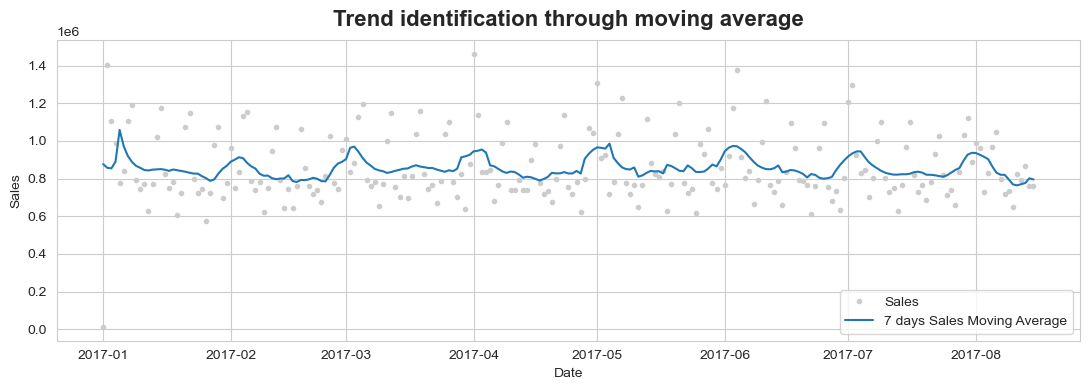

In [51]:
_, ax = plt.subplots()
plot_moving_average_trend(total_sales, get_moving_average(total_sales,  7), ax=ax, plot_sales=True, window_days=7)

### Identifying trend with DeterministicProcess and a LinearRegression

In [52]:
dp = DeterministicProcess(index=total_sales.index, constant=True, order=1)

In [53]:
trend_features = dp.in_sample()

In [54]:
from sklearn.linear_model import LinearRegression

In [55]:
model = LinearRegression(fit_intercept=False,n_jobs=3)

In [56]:
model.fit(trend_features, total_sales)

LinearRegression(fit_intercept=False, n_jobs=3)

In [57]:
model.coef_, model.intercept_

(array([ 8.56212948e+05, -5.53639369e+00]), 0.0)

In [58]:
first_order_lin_reg = pd.Series(model.predict(trend_features), index=total_sales.index, name="1st order trend lin reg")

In [59]:
dp2 = DeterministicProcess(index=total_sales.index, constant=True, order=2)
trend_2nd_features = dp2.in_sample()
model2 = model.fit(trend_2nd_features, total_sales)

print((model2.coef_, model2.intercept_))

second_order_lin_reg = pd.Series(model2.predict(trend_2nd_features), index=total_sales.index, name="2nd order trend lin reg")

(array([ 8.38550321e+05,  4.57239847e+02, -2.02972035e+00]), 0.0)


### Comparison between strategies to get the trend of sales 

<Axes: title={'center': 'Trend Plot of sales'}, xlabel='Date', ylabel='sales'>

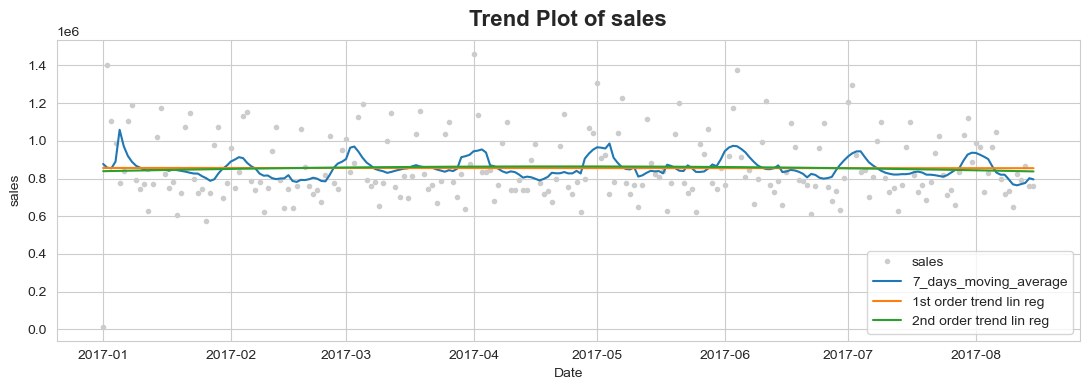

In [60]:
_, ax = plt.subplots()
plot_trend(total_sales, get_moving_average(total_sales,  7), ax=ax, plot_series=True)
plot_trend(total_sales, first_order_lin_reg, ax=ax, plot_series=False)
plot_trend(total_sales, second_order_lin_reg, ax=ax, plot_series=False)

### Identifying seasonality through dummy seasonal variables
- Recap: 4 frequencies with highest variance: Monthly, Biweekly, Weekly and Semiweekly
- We can use DeterministicProcess in order to generate seasonal dummy features to indicate whether a data point belongs to a specific seasonal "day"
- On daily sampled time series, seasonal features are "weekly", which means there is a feature for each `dayofweek`
- This will help our model to capture weekly and semi-weekly features, so let's start by that

In [61]:
dp_seasonal = DeterministicProcess(index=total_sales.index, period=7, constant=True, order=1, seasonal=True)
seasonal_features = dp_seasonal.in_sample()
seasonal_features.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)"
date,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0


In [62]:
model_seasonal_dummies = LinearRegression(fit_intercept=False, n_jobs=3)

In [63]:
model_seasonal_dummies.fit(seasonal_features,total_sales)

LinearRegression(fit_intercept=False, n_jobs=3)

In [64]:
seasonal_features_forecast = pd.Series(model_seasonal_dummies.predict(seasonal_features), index= total_sales.index, name="Forecast")

<Axes: title={'center': 'Sales Forecasts'}, xlabel='Date', ylabel='sales'>

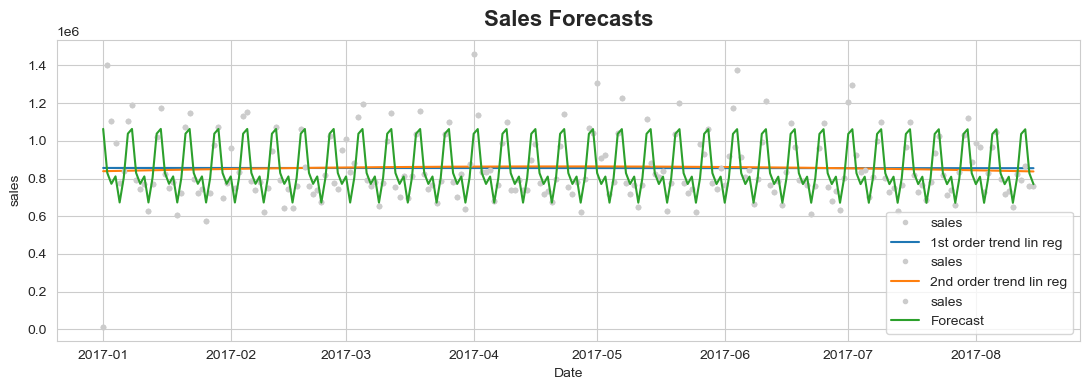

In [65]:
_, ax = plt.subplots()
plot_regression(total_sales, first_order_lin_reg, ax=ax, title="Sales Forecasts")
plot_regression(total_sales, second_order_lin_reg, ax=ax)
plot_regression(total_sales, seasonal_features_forecast, ax=ax) 

<Axes: xlabel='Date', ylabel='sales'>

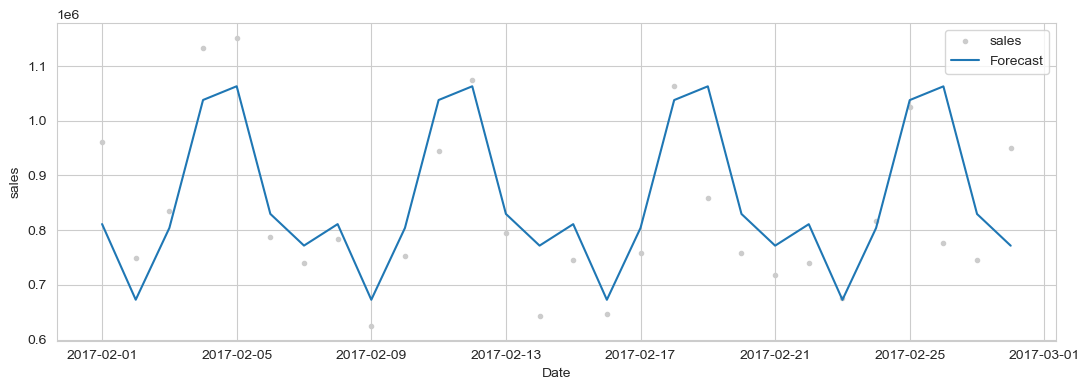

In [66]:
plot_regression(total_sales.loc["2017-02"], seasonal_features_forecast.loc["2017-02"])

### Identifying seasonalities through fourier components
- Let's try to improve our model of total sales based on the monthly and bi weekly seasonalities modeled through Fourier compoents

In [67]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

<Axes: title={'center': 'Periodgram'}, ylabel='Variance'>

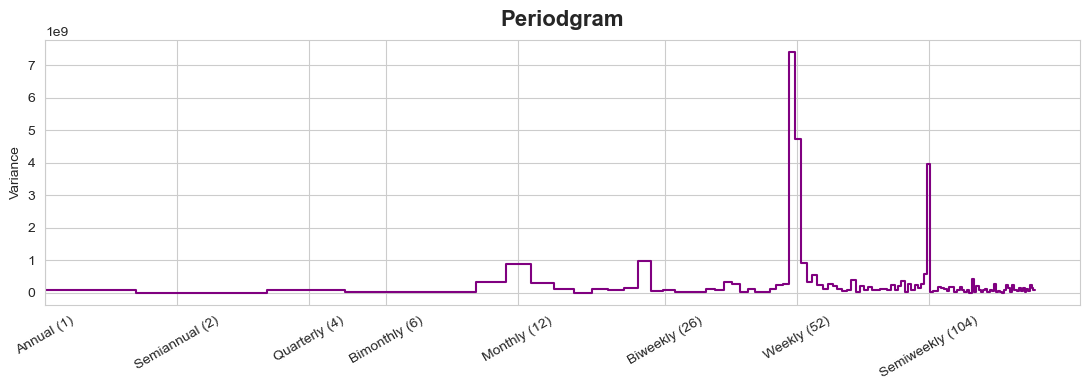

In [68]:
plot_periodogram(total_sales)

In [69]:
calend = CalendarFourier(freq="M", order=3)

In [70]:
fourrier_features = calend.in_sample(index=total_sales.index)
fourrier_features.head()

,"sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)"
date,,,,,,
2017-01-01,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763
2017-01-03,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305
2017-01-04,0.571268,0.820763,0.937752,0.347305,0.968077,-0.250653
2017-01-05,0.724793,0.688967,0.998717,-0.050649,0.651372,-0.758758


In [71]:
calend

Fourier(freq=M, order=3) at 0x15d164d2e00

Text(0.5, 1.0, 'Fourrier Features - Sin(x)')

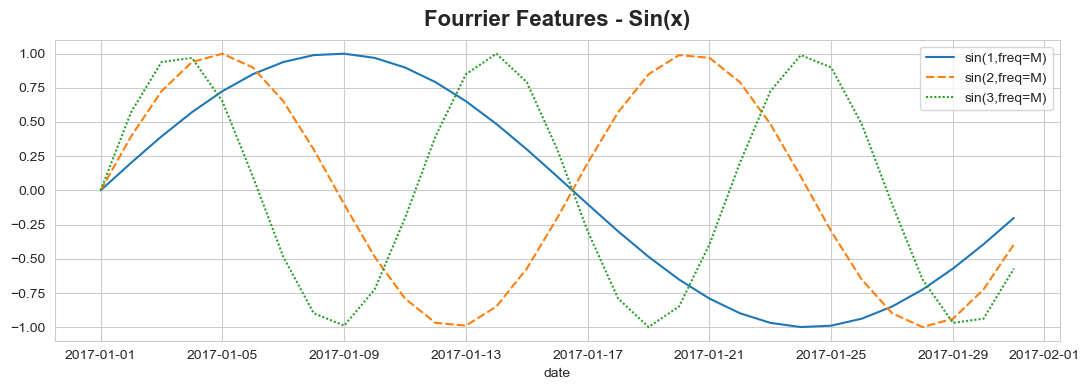

In [72]:
ax = sns.lineplot(fourrier_features.loc[:, fourrier_features.columns.str.startswith("sin(")].loc["2017-01"])
ax.set_title("Fourrier Features - Sin(x)")

In [73]:
dp_trend_season_fourr = DeterministicProcess(
    index=total_sales.index,
    period=7,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[calend]
)

In [74]:
X = dp_trend_season_fourr.in_sample()
y = total_sales

In [75]:
model_total_sales = LinearRegression(fit_intercept=False, n_jobs=3)

In [76]:
model_total_sales.fit(X, y)

LinearRegression(fit_intercept=False, n_jobs=3)

In [77]:
y_pred = pd.Series(model_total_sales.predict(X), 
                   index=y.index, 
                   name="1st order Trend + 7 days dummy + 3 order Monthly Fourrier Components")

<Axes: title={'center': 'Sales Forecasts'}, xlabel='Date', ylabel='sales'>

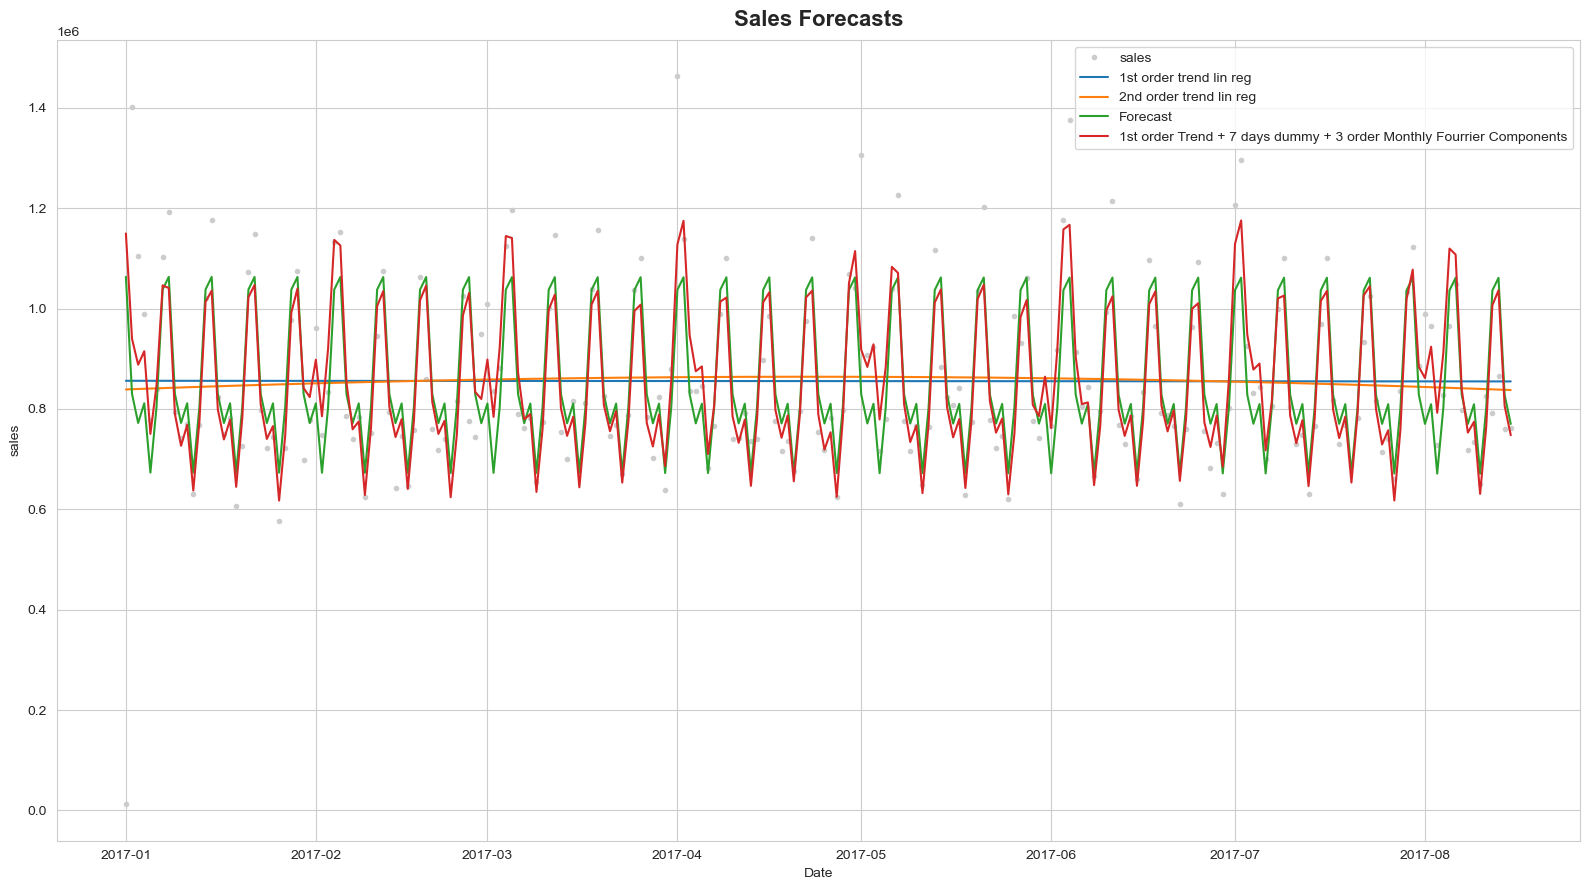

In [78]:
_, ax = plt.subplots(figsize=(16,9))
plot_regression(y, first_order_lin_reg, ax=ax, title="Sales Forecasts")
plot_regression(regression_series=second_order_lin_reg, ax=ax)
plot_regression(regression_series=seasonal_features_forecast, ax=ax) 
plot_regression(regression_series=y_pred, ax=ax)

In [79]:
from sklearn.metrics import mean_squared_log_error

In [80]:
results = {
    "Trend + Seasonal Model" : mean_squared_log_error(y, seasonal_features_forecast),
    "Trend + Seasonal + Fourrier Model" : mean_squared_log_error(y, y_pred)
}
results

{'Trend + Seasonal Model': 0.09923137753016643,
 'Trend + Seasonal + Fourrier Model': 0.09804550952792888}

### Going beyond the linear regression
- What if we use a stronger model, maybe we can achive better results?

In [81]:
from sklearn.ensemble import RandomForestRegressor

In [82]:
rf_model = RandomForestRegressor(n_jobs=3)
rf_model.fit(X,y)

RandomForestRegressor(n_jobs=3)

In [83]:
y_pred_rf = pd.Series(rf_model.predict(X), y.index, name="Random Forest Regressor")

<Axes: title={'center': 'Sales Forecasts'}, xlabel='Date', ylabel='sales'>

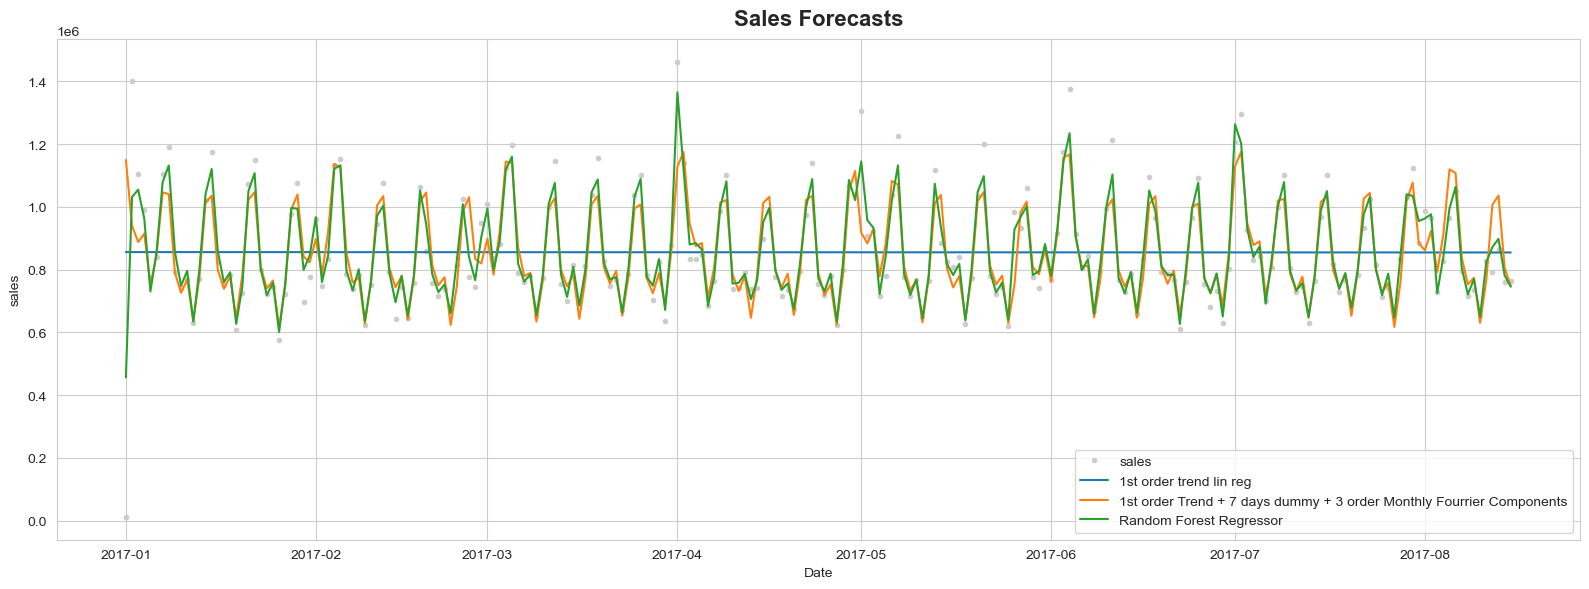

In [84]:
_, ax = plt.subplots(figsize=(16,6))
plot_regression(y, first_order_lin_reg, ax=ax, title="Sales Forecasts")
plot_regression(regression_series=y_pred, ax=ax)
plot_regression(regression_series=y_pred_rf, ax=ax)

In [85]:
results["Random Forest Regressor"] = mean_squared_log_error(y, y_pred_rf)
results

{'Trend + Seasonal Model': 0.09923137753016643,
 'Trend + Seasonal + Fourrier Model': 0.09804550952792888,
 'Random Forest Regressor': 0.05993464495255292}

## Strategy 3: Adding Holidays

In [86]:
holidays = pd.read_csv("inputs/holidays_events.csv", index_col=["date"], parse_dates=["date"], infer_datetime_format=True)
holidays.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [87]:
stores = pd.read_csv("inputs/stores.csv", index_col=["store_nbr"])
stores.head()

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [88]:
holidays["type"].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [89]:
holidays["locale"].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [90]:
print("States: ", holidays.loc[holidays.locale == "Regional"]["locale_name"].unique())
print("Cities: ", holidays.loc[holidays.locale == "Local"]["locale_name"].unique())

States:  ['Cotopaxi' 'Imbabura' 'Santo Domingo de los Tsachilas' 'Santa Elena']
Cities:  ['Manta' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda' 'Latacunga'
 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe' 'Esmeraldas' 'Ambato'
 'Ibarra' 'Quevedo' 'Quito' 'Loja' 'Salinas' 'Guayaquil']


In [91]:
# # (holidays.index >= "2017") & 
# holidays["is_local_holiday"] = 0
# holidays["is_regional_holiday"] = 0
# holidays["is_national_holiday"] = 0

# holidays.loc[(holidays["transferred"] == False),""] = 1

In [92]:
# Before anything else, let's observe the possible impact of the holidays

national_holidays = pd.Series(
    data = 1, 
    index=holidays.loc[(holidays.index >= "2017") & (holidays["transferred"] == False) & (holidays["locale"].isin(["National","Regional"]))].index,
    name="is_national_holiday"
)

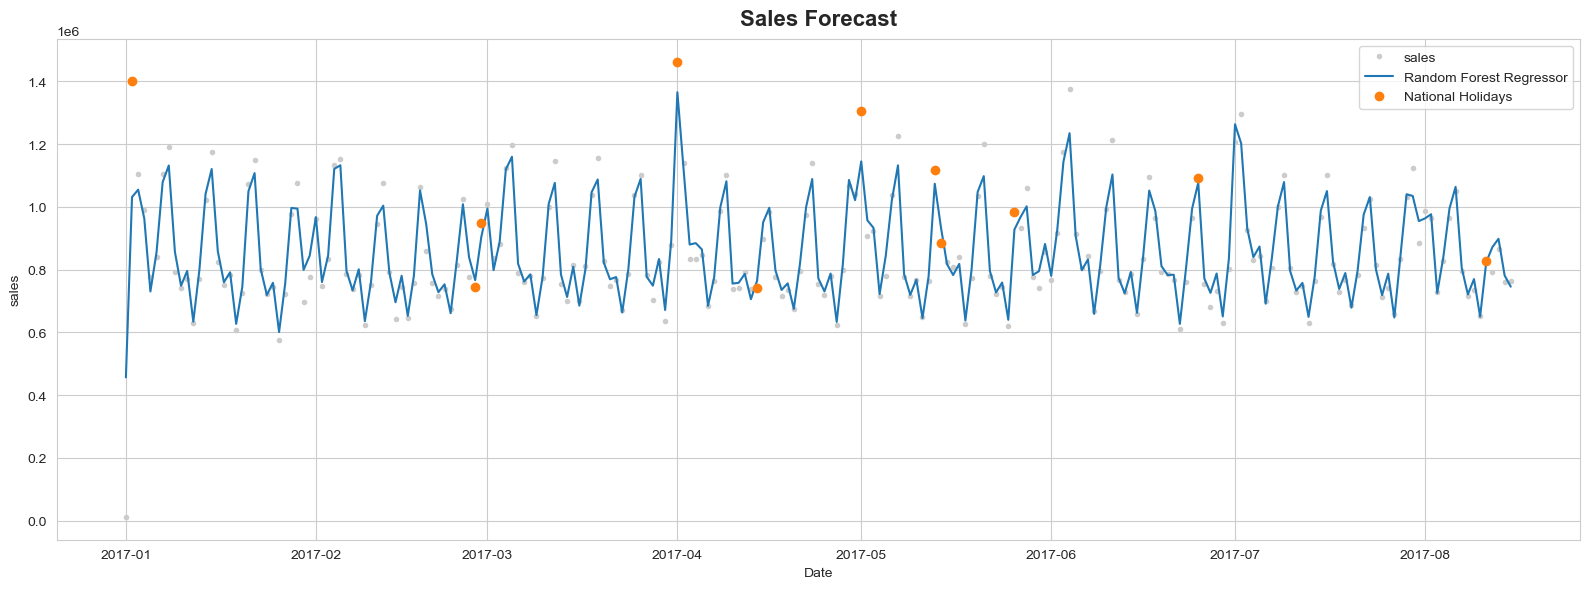

In [93]:
df_plot = pd.DataFrame(y).join(national_holidays)

_, ax = plt.subplots(figsize=(16,6))
ax = plot_regression(y, regression_series=y_pred_rf, ax=ax, title="Sales Forecast")
ax.plot(df_plot[df_plot.is_national_holiday == 1].index, df_plot[df_plot.is_national_holiday == 1].sales, "o", label="National Holidays")
ax.legend()

<Axes: title={'center': 'Periodgram'}, ylabel='Variance'>

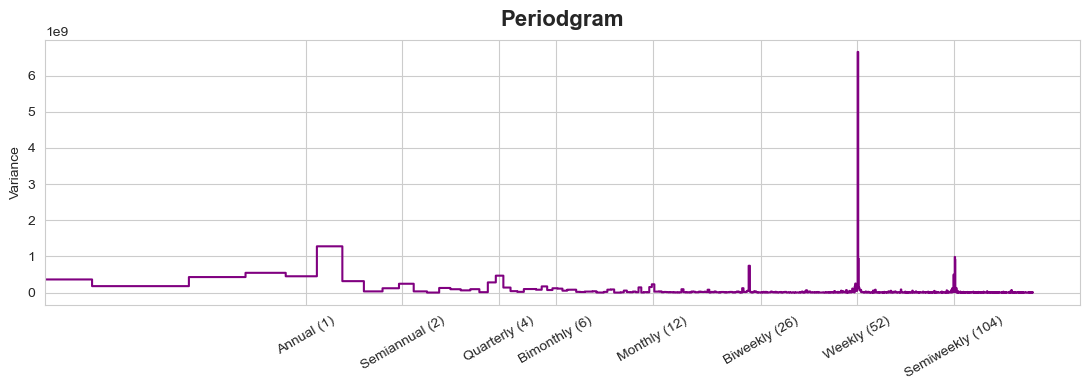

In [94]:
# Also, let's observe if are tere any annual seasonalities in full data 
plot_periodogram(train.drop(["id","onpromotion"], axis=1).groupby(level=["date"]).sum()["sales"])

In [95]:
dp_trend_season_fourr = DeterministicProcess(
    index=total_sales.index,
    period=7,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[calend]
)

In [96]:
X = dp_trend_season_fourr.in_sample().join(national_holidays).fillna(0)

In [97]:
y = total_sales

In [98]:
import lightgbm

In [99]:
model = lightgbm.LGBMRegressor(n_jobs=3, random_state=0)

In [100]:
model.fit(X.values, y.values)

LGBMRegressor(n_jobs=3, random_state=0)

In [101]:
y_pred_lgbm = pd.Series(model.predict(X.values), y.index, name="LGBM Regression")

In [102]:
results["LGBM, Trends, Season Dummies, Fourrier and Holidays"] = mean_squared_log_error(y, y_pred_lgbm)
results

{'Trend + Seasonal Model': 0.09923137753016643,
 'Trend + Seasonal + Fourrier Model': 0.09804550952792888,
 'Random Forest Regressor': 0.05993464495255292,
 'LGBM, Trends, Season Dummies, Fourrier and Holidays': 0.08180469040495963}

In [103]:
model_rf = RandomForestRegressor(n_jobs=3, random_state=0)
model_rf.fit(X,y)

RandomForestRegressor(n_jobs=3, random_state=0)

In [104]:
y_pred_rf_2 = pd.Series(model_rf.predict(X), y.index, name="Random Forest Regression w/ Holidays")

In [105]:
results["Random Forest Regressor with Holidays"] = mean_squared_log_error(y, y_pred_rf_2)
results

{'Trend + Seasonal Model': 0.09923137753016643,
 'Trend + Seasonal + Fourrier Model': 0.09804550952792888,
 'Random Forest Regressor': 0.05993464495255292,
 'LGBM, Trends, Season Dummies, Fourrier and Holidays': 0.08180469040495963,
 'Random Forest Regressor with Holidays': 0.0538622469438558}

<Axes: title={'center': 'Sales Forecasts'}, xlabel='Date', ylabel='sales'>

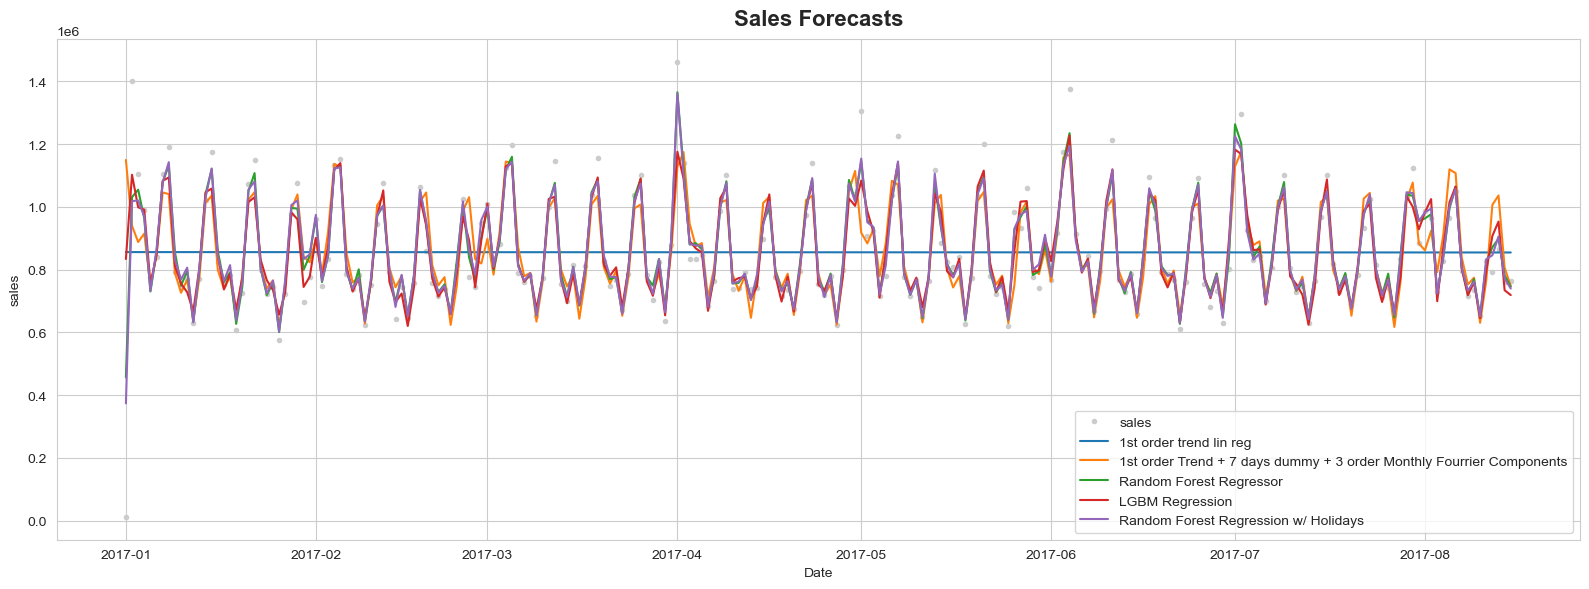

In [106]:
_, ax = plt.subplots(figsize=(16,6))
plot_regression(y, first_order_lin_reg, ax=ax, title="Sales Forecasts")
plot_regression(regression_series=y_pred, ax=ax)
plot_regression(regression_series=y_pred_rf, ax=ax)
plot_regression(regression_series=y_pred_lgbm, ax=ax)
plot_regression(regression_series=y_pred_rf_2, ax=ax)

In [107]:
from sklearn.metrics import mean_squared_error

In [108]:
mean_squared_error(y, y_pred_rf_2,squared=False)

51167.21462322072

# Time to predict for real (product/family category
- We are using trends + season dummies + fourrier components + holidays
- We are only using 2017 data for training
- We are to test 4 models: LinearRegressor, RandomForestRegressor, LGBMRegressor, XGBRegressor
- We are to evaluate our models under RMLSE

In [109]:
train

id  sales  onpromotion
store_nbr family     date                                   
1         AUTOMOTIVE 2013-01-01        0    0.0            0
                     2013-01-02     1782    2.0            0
                     2013-01-03     3564    3.0            0
                     2013-01-04     5346    3.0            0
                     2013-01-05     7128    5.0            0
...                                  ...    ...          ...
54        SEAFOOD    2017-08-11  2993627    0.0            0
                     2017-08-12  2995409    1.0            1
                     2017-08-13  2997191    2.0            0
                     2017-08-14  2998973    0.0            0
                     2017-08-15  3000755    3.0            0

[3000888 rows x 3 columns]

In [110]:
def get_time_series_dp(date_time_index):
    
    # Parameters
    SEASONAL_DUMMIES_PERIOD = 7
    TREND_ORDER = 1
    INCLUDE_TREND_CONSTANT= True
    IS_SEASONAL = True
    FOURRIER_FREQ = "M"
    FOURRIER_ORDER = 3
    
    # Fourrier Calendar helper
    calend = CalendarFourier(
        freq=FOURRIER_FREQ, 
        order= FOURRIER_ORDER
    )
    
    # Creates trend, dummies and fourrier calendar features
    dp = DeterministicProcess(
        index=date_time_index, 
        period=SEASONAL_DUMMIES_PERIOD, 
        constant = INCLUDE_TREND_CONSTANT, 
        order= TREND_ORDER, 
        seasonal= IS_SEASONAL, 
        additional_terms=[calend], 
        drop=True
    )
    

    # Returns DP as it is going to be further used to generate the test dataset features
    return dp

def get_train_and_test_predictors(deterministic_process, forecast_index):
    train_df_X = deterministic_process.in_sample()
    test_df_X = deterministic_process.out_of_sample(steps=len(forecast_index),forecast_index=forecast_index)
    
    return train_df_X, test_df_X

In [111]:
train_datetime_index = train.drop(["id","onpromotion"], axis=1).unstack(["store_nbr","family"]).index
test_datetime_index = test.drop(["id","onpromotion"], axis=1).unstack(["store_nbr","family"]).index

In [112]:
forecast_window_time_delta = test_datetime_index.max() - test_datetime_index.min()
forecast_window_time_delta

Timedelta('15 days 00:00:00')

In [113]:
(train_datetime_index.max() - train_datetime_index.min()) // forecast_window_time_delta

112

In [114]:
from sklearn.model_selection import TimeSeriesSplit

In [115]:
tscv = TimeSeriesSplit(n_splits=112)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=112, test_size=None)

In [116]:
unstacked_train = train.drop(["id","onpromotion"], axis=1).unstack(["store_nbr","family"])
unstacked_train_index = unstacked_train.index
unstacked_test_index = test.drop(["id","onpromotion"], axis=1).unstack(["store_nbr","family"]).index

In [117]:
dp = get_time_series_dp(unstacked_train_index)
X, X_test = get_train_and_test_predictors(dp, unstacked_test_index)

In [118]:
print(X.shape, X_test.shape)

(1684, 14) (16, 14)


In [119]:
y = unstacked_train.copy()

In [120]:
model = LinearRegression(n_jobs=3,fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index= y.index, columns= y.columns)

# Predictions below zero are going to result in error, so we should cap at zero
print(f"predictions < 0: {100*(y_pred < 0.0).sum().sum() / (y_pred.shape[0] * y_pred.shape[1]): .2f} %")

y_pred = y_pred.mask(y_pred < 0, 0)

print(f"predictions < 0: {100*(y_pred < 0.0).sum().sum() / (y_pred.shape[0] * y_pred.shape[1]): .2f} %")

print("Error: ", mean_squared_log_error(y, y_pred, squared=False))

predictions < 0:  5.92 %
predictions < 0:  0.00 %
Error:  0.9122006270690907


In [129]:
from sklearn.multioutput import MultiOutputRegressor

In [133]:
y = unstacked_train.copy()

models =[
    ("Linear Regression", LinearRegression(n_jobs=3,fit_intercept=False)),
    ("Random Forest 20", RandomForestRegressor(n_estimators=20, n_jobs=3, random_state=0)),
    ("Random Forest 100", RandomForestRegressor(n_estimators=100, n_jobs=3, random_state=0)),
    # ("LightGBM", MultiOutputRegressor(lightgbm.LGBMRegressor(n_jobs=3, random_state=0), n_jobs=3)),
]

In [125]:
def get_model_scores(model, ts, n_splits=5):
    scores = []
    splitter = TimeSeriesSplit(n_splits=n_splits)
    
    for idx, (train_idx, valid_idx) in enumerate(splitter.split(y.index, y)):
        # We are discarding validation indexes from TimeSeriesSplit as we are interested in predicting the next 15 days
        valid_idx = [i for i in range(train_idx.max()+1, train_idx.max()+16)]
        
        dp = get_time_series_dp(y.iloc[train_idx].index)
        
        X_train, X_valid = get_train_and_test_predictors(dp, y.iloc[valid_idx].index)
        
        y_train = y.iloc[train_idx]
        y_valid = y.iloc[valid_idx]
        
        model.fit(X_train.values, y_train.values)
        y_pred = pd.DataFrame(model.predict(X_valid.values), index= y_valid.index, columns= y_valid.columns)
        y_pred = y_pred.mask(y_pred < 0, 0)

        scores.append(mean_squared_log_error(y_valid, y_pred, squared=False))
    return np.array(scores)

In [134]:
TimeSeriesSplitults = []
for model in models:
    model_name = model[0]
    scores = get_model_scores(model[1], y, n_splits=10)
    print(model_name, ": ", scores)
    model_results.append((model_name, scores))

model_results

Linear Regression :  [0.229368   0.25204219 0.88154358 0.50674797 0.92352504 0.47727079
 0.54918149 0.47670777 0.57581697 0.47557261]
Random Forest 20 :  [0.22331057 0.23427754 0.70547195 0.48044894 0.44834991 0.36006768
 0.47392973 0.41590874 0.44456673 0.43687267]
Random Forest 100 :  [0.21736452 0.23109925 0.70554472 0.47014622 0.43777037 0.35071107
 0.46786095 0.41645639 0.43485322 0.43373967]


[('Linear Regression',
  array([0.229368  , 0.25204219, 0.88154358, 0.50674797, 0.92352504,
         0.47727079, 0.54918149, 0.47670777, 0.57581697, 0.47557261])),
 ('Random Forest 20',
  array([0.22331057, 0.23427754, 0.70547195, 0.48044894, 0.44834991,
         0.36006768, 0.47392973, 0.41590874, 0.44456673, 0.43687267])),
 ('Random Forest 100',
  array([0.21736452, 0.23109925, 0.70554472, 0.47014622, 0.43777037,
         0.35071107, 0.46786095, 0.41645639, 0.43485322, 0.43373967]))]

In [135]:
dict([(results[0], results[1].mean()) for results in model_results])

{'Linear Regression': 0.5347776404863926,
 'Random Forest 20': 0.42232044585028705,
 'Random Forest 100': 0.41655463803591275}

# Training final model and submitting results

In [137]:
dp = get_time_series_dp(unstacked_train_index)
X, X_test = get_train_and_test_predictors(dp, unstacked_test_index)

y = unstacked_train.copy()

print(X.shape, X_test.shape)
print(y.shape)

(1684, 14) (16, 14)
(1684, 1782)


In [139]:
model = RandomForestRegressor(n_estimators=100, n_jobs=3, random_state=0)

In [140]:
model.fit(X, y)

RandomForestRegressor(n_jobs=3, random_state=0)

In [141]:
y_pred = pd.DataFrame(model.predict(X_test), index = X_test.index, columns= y.columns)
print(y_pred.shape)
y_pred.head()

(16, 1782)


sales                                                \
store_nbr          1                                                  
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-08-16       2.99       0.0   4.37   2434.60  0.93   438.702992   
2017-08-17       5.10       0.0   3.72   2124.49  0.28   346.733130   
2017-08-18       5.85       0.0   3.19   2196.34  0.19   346.938950   
2017-08-19       5.23       0.0   3.36   2052.08  0.03   312.453440   
2017-08-20       1.33       0.0   1.89   1016.46  0.03   155.058960   

                                                    ...                       \
store_nbr                                           ...        54              
family     CELEBRATION CLEANING   DAIRY       DELI  ... MAGAZINES      MEATS   
date                                                ...                        
2017-08-16       22.29   845.47  829.64  142.18518  ...      0.70  43.275570   
2017-08-17       19.26   671.98  724.70  121.25039  ...      0.37  61.015970   
2017-08-18       18.99   670.20  678.46  149.82514  ...      0.56  49.319309   
2017-08-19       10.66   517.59  643.66  119.93328  ...      1.83  57.073961   
2017-08-20        3.05   221.72  333.04   63.36413  ...      1.15  65.343840   

                                                                         \
store_nbr                                                                 
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   POULTRY   
date                                                                      
2017-08-16        139.72         0.01                    2.41  46.60638   
2017-08-17        138.73         0.02                    1.44  55.69658   
2017-08-18        163.59         0.56                    3.94  65.23772   
2017-08-19        201.64         0.09                    3.51  80.24165   
2017-08-20        307.55         0.26                    2.80  97.22415   

                                                                         
store_nbr                                                                
family     PREPARED FOODS    PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                     
2017-08-16          85.13  523.82065                       2.31    2.36  
2017-08-17          71.14  511.64343                       0.21    1.44  
2017-08-18          71.98  585.10732                       0.01    1.47  
2017-08-19          75.29  723.10532                       0.41    2.27  
2017-08-20         126.46  875.18929                       0.87    3.65  

[5 rows x 1782 columns]

In [142]:
stacked_y_pred = y_pred.stack(level=["store_nbr","family"]).reorder_levels(["store_nbr","family","date"])
print(stacked_y_pred.shape)
stacked_y_pred.head()

(28512, 1)


sales
store_nbr family     date               
1         AUTOMOTIVE 2017-08-16     2.99
          BABY CARE  2017-08-16     0.00
          BEAUTY     2017-08-16     4.37
          BEVERAGES  2017-08-16  2434.60
          BOOKS      2017-08-16     0.93

In [153]:
submission_df = test[["id"]].join(stacked_y_pred,how="left")

In [155]:
submission_df.head()

id  sales
store_nbr family     date                      
1         AUTOMOTIVE 2017-08-16  3000888   2.99
                     2017-08-17  3002670   5.10
                     2017-08-18  3004452   5.85
                     2017-08-19  3006234   5.23
                     2017-08-20  3008016   1.33

In [156]:
submission_df.to_csv("./outputs/submission.csv",index=False)

In [157]:
! head -5 ./outputs/submission.csv

id,sales
3000888,2.99
3002670,5.1
3004452,5.85
3006234,5.23


In [158]:
! wc -l ./outputs/submission.csv

28513 ./outputs/submission.csv


<Axes: title={'center': 'Final Model Predicton on Train Data'}, xlabel='Date', ylabel='predictions'>

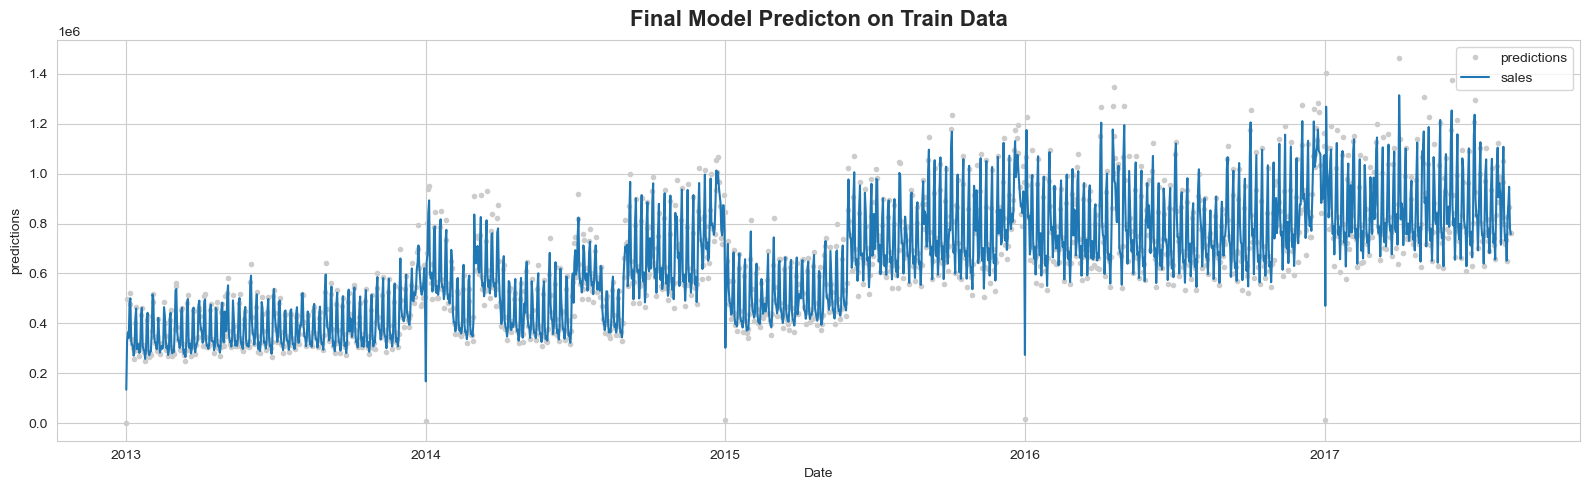

In [172]:
train_data_predictions = pd.DataFrame(model.predict(X), index=y.index, columns=y.columns)
total_predicted_sales = train_data_predictions.stack(level=["store_nbr","family"]).groupby(level=["date"]).sum()["sales"]
total_sales = y.stack(level=["store_nbr","family"]).groupby(level=["date"]).sum()["sales"].rename("predictions")


fig, ax = plt.subplots(figsize=(16,5))
plot_regression(total_sales, total_predicted_sales, 
                title="Final Model Predicton on Train Data",
                ax=ax)

<Axes: title={'center': 'Final Model Predicton on Train Data'}, xlabel='Date', ylabel='predictions'>

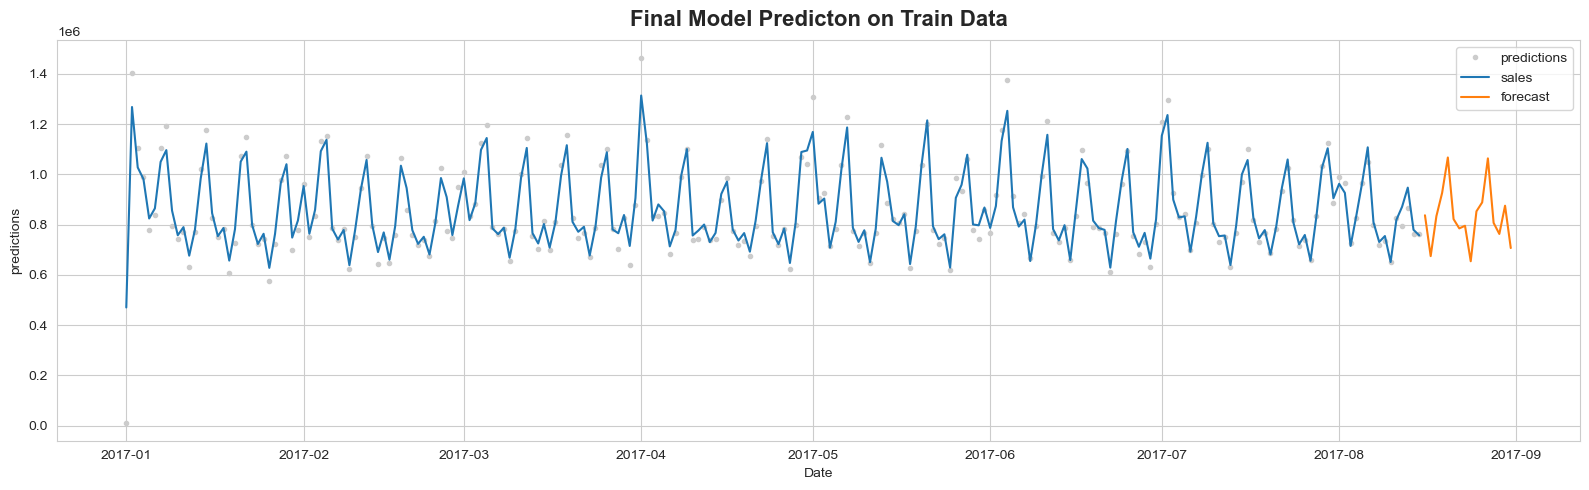

In [176]:
fig, ax = plt.subplots(figsize=(16,5))
plot_regression(total_sales.loc["2017"], 
                total_predicted_sales.loc["2017"], 
                title="Final Model Predicton on Train Data",
                ax=ax)
plot_regression(regression_series=y_pred.stack(level=["store_nbr","family"]).groupby(level=["date"]).sum()["sales"].rename("forecast"), ax=ax)